## Business Understanding

Knowing what the next play is in any sport would be a huge advantage. The question I want to explore is whether or not data can accurately provide the defense with this advantage in the game of football.

With the help of machine learning, I've created a model that takes in play-by-play data before the snap occurs and predicts whether that play will be a run or pass. My hope is that this information can be beneficial to coaching staffs in the NFL when it comes to game preparation and live play calling.

## Data Understanding

I used a package called nflfastR to source my data, which is based off of the nflscrapR package, but it speeds up the process of scraping new play-by-play data. This package was created so its users could analyze data from the National Football League API in a more reproducible way for the continued growth of football analytics. It allowed me to perform analysis on roughly 90,000 plays from the seasons 2018 to 2020. Having chosen recent seasons to perform analysis on, I should be able to pick up on play calling trends to allow for better extrapolation into the future.

The features I felt had the most impact on whether a run or pass play would occur were things like the time, the down, the score, yards to gain, timeouts, winning probability, and the formation an offense lined up in.

The reason I chose these features was due to the strategic approach many coaches take in certain game scenarios. In the rules of football, incomplete passes will stop the game clock and running the football keeps the clock moving unless the running back is forced out of bounds. Many coaches use this rule in a way that is beneficial to their team, as they should. For example, if your team is losing and there isn’t much time left, most coaches won’t want to run the football and risk letting the clock continue to tick away, as they are trying to preserve time and move the football in large chunks in order to score. Vice versa, if you your team is winning by a large margin and there’s still a decent amount of time left, a coach might make the executive decision to change the play script and run the football, so the clock keeps moving.

In [248]:
# importing data
import pandas as pd
import pickle

# train_test_split & cross validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

# creating piplines
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

# machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import cv2

# grabbing team logos
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import numpy as np

## Data Retrieval & Preparation

In [1]:
# looking at play-by-play data over a 3 year span
years = [2018, 2019, 2020]

df = pd.DataFrame()

for i in years:  
    # low_memory=False eliminates a warning
    i_df = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(i) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

    # sort=True eliminates a warning and alphabetically sorts columns
    df = df.append(i_df, sort=True)

# give each row a unique index
df.reset_index(drop=True, inplace=True)

In [2]:
df.head()

,aborted_play,air_epa,air_wpa,air_yards,assist_tackle,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,...,xyac_median_yardage,xyac_success,yac_epa,yac_wpa,yardline_100,yards_after_catch,yards_gained,ydsnet,ydstogo,yrdln
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,PHI 35
1,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.0,NaN,0.0,73.0,0,PHI 35
2,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,75.0,NaN,0.0,73.0,10,ATL 25
3,0,0.321213,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,...,2.0,0.998706,0.528905,0.038693,80.0,2.0,10.0,73.0,15,ATL 20
4,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,70.0,NaN,11.0,73.0,5,ATL 30


In [3]:
df.shape

(125356, 340)

In [4]:
# only using regular season data
df = df.loc[df.season_type=='REG']

In [5]:
# the dataset labels QB scrambles as a run, when in reality they are passing plays
df.play_type.loc[df['pass']==1] = 'pass'
df.play_type.loc[df.rush==1] = 'run'

/Users/jonhickey/opt/anaconda3/envs/learn-env-2/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
# pickle original dataset
df.to_pickle('df.pkl')

In [7]:
# decide which feaures will be valuable for run/pass predictions
run_pass_df = df[['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 
    'drive', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'play_type', 'shotgun', 'no_huddle', 
    'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential',
    'wp']]

In [8]:
# turn seconds into minutes
run_pass_df['quarter_minutes_remaining'] = round(run_pass_df['quarter_seconds_remaining']/60, 2)
run_pass_df['half_minutes_remaining'] = round(run_pass_df['half_seconds_remaining']/60, 2)
run_pass_df['game_minutes_remaining'] = round(run_pass_df['game_seconds_remaining']/60, 2)

<ipython-input-8-b4737577b4af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_pass_df['quarter_minutes_remaining'] = round(run_pass_df['quarter_seconds_remaining']/60, 2)
<ipython-input-8-b4737577b4af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_pass_df['half_minutes_remaining'] = round(run_pass_df['half_seconds_remaining']/60, 2)
<ipython-input-8-b4737577b4af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
run_pass_df = run_pass_df.drop(['quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining'], axis=1)

In [10]:
# grab all plays that are run or pass
run_pass_df = run_pass_df.loc[(run_pass_df['play_type'] == 'pass') | (run_pass_df['play_type'] == 'run')]

In [11]:
# create Target column consisting of 0's and 1's for run and pass
run_pass_df['Target'] = run_pass_df.play_type.map(lambda x: 1 if x == 'pass' else 0)

In [12]:
# drop play_type once we've created our target column
run_pass_df.drop(['play_type'], axis = 1, inplace = True)

In [13]:
run_pass_df.isna().sum()

yardline_100                  128
drive                           1
qtr                             0
down                          354
goal_to_go                      0
ydstogo                         0
shotgun                         0
no_huddle                       0
posteam_timeouts_remaining    128
defteam_timeouts_remaining    128
posteam_score                 128
defteam_score                 128
score_differential            128
wp                            128
quarter_minutes_remaining       3
half_minutes_remaining          3
game_minutes_remaining          3
Target                          0
dtype: int64

In [14]:
# drop NaN values
run_pass_df = run_pass_df.dropna()

In [15]:
run_pass_df.isna().sum()

yardline_100                  0
drive                         0
qtr                           0
down                          0
goal_to_go                    0
ydstogo                       0
shotgun                       0
no_huddle                     0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
posteam_score                 0
defteam_score                 0
score_differential            0
wp                            0
quarter_minutes_remaining     0
half_minutes_remaining        0
game_minutes_remaining        0
Target                        0
dtype: int64

In [212]:
# SMOTE will be used to balance my target variables
run_pass_df.Target.value_counts()

1    55188
0    33166
Name: Target, dtype: int64

In [216]:
runs = run_pass_df.Target.value_counts()[0]
passes = run_pass_df.Target.value_counts()[1]

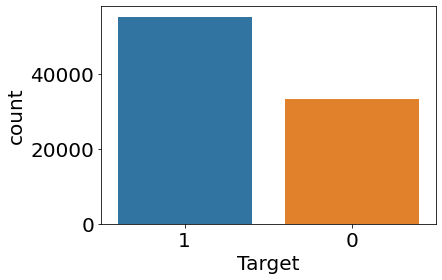

In [226]:
# play data is pass heavy, therefore we will need to use SMOTE in our pipeline
sns.countplot(data = run_pass_df, x = 'Target', order= run_pass_df['Target'].value_counts().index);

In [17]:
run_pass_df.to_pickle('run_pass_df.pkl')

In [18]:
run_pass_df.shape

(88354, 18)

In [19]:
run_pass_df.head()

,yardline_100,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,quarter_minutes_remaining,half_minutes_remaining,game_minutes_remaining,Target
3,80.0,1.0,1,1.0,0,15,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,15.00,30.00,60.00,1
4,70.0,1.0,1,2.0,0,5,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,14.37,29.37,59.37,0
5,59.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,13.77,28.77,58.77,0
6,39.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,13.17,28.17,58.17,1
7,39.0,1.0,1,2.0,0,10,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,13.08,28.08,58.08,1


## Explosive Play Analysis

The purpose of this analysis was to mimic the concept of explosive plays created by Mike Eayrs in the 70's and 80's. The goal was to see how run plays of 12 or more yards and pass plays of 16 or more yards affected your ability to win.

In [195]:
# grabbing my dataset from the years 2018-2020
df2 = pd.read_pickle('df.pkl')

In [196]:
xpp_xrp_df = df2[['game_date', 'yards_gained', 'play_type', 'posteam', 'defteam', 'down', 'fourth_down_failed']]

In [197]:
# drop NaN's
xpp_xrp_df = xpp_xrp_df.dropna()

In [198]:
# grab all plays that are run or pass
xpp_xrp_df = xpp_xrp_df.loc[(xpp_xrp_df['play_type'] == 'pass') | (xpp_xrp_df['play_type'] == 'run')]

In [199]:
# grab all plays that had over 16 yards passed or 12 yards rushed
xpp_xrp_df = xpp_xrp_df.loc[(xpp_xrp_df['yards_gained'] >= 16) & (xpp_xrp_df['play_type'] == 'pass')
                            | (xpp_xrp_df['yards_gained'] >= 12) & (xpp_xrp_df['play_type'] == 'run')]

In [200]:
xpp_xrp_df.play_type.value_counts()

pass    7017
run     2630
Name: play_type, dtype: int64

In [201]:
# weed out 4th down plays that pick up 16 pass yards or 12 rush yards but fail to convert 1st down
xpp_xrp_df.loc[(xpp_xrp_df['fourth_down_failed'] == 1) & (xpp_xrp_df['yards_gained'] >= 12)]

,game_date,yards_gained,play_type,posteam,defteam,down,fourth_down_failed
6605,2018-09-23,20.0,pass,DAL,SEA,4.0,1.0
29350,2018-11-22,27.0,pass,ATL,NO,4.0,1.0
38514,2018-12-15,16.0,pass,NYJ,HOU,4.0,1.0
52695,2019-09-15,17.0,pass,MIA,NE,4.0,1.0
120430,2020-11-15,19.0,pass,CIN,PIT,4.0,1.0


In [202]:
xpp_xrp_df = xpp_xrp_df.drop([6605, 29350, 38514, 52695, 120430], axis=0)

In [203]:
# you can see these 5 pass plays are no longer in the dataframe
xpp_xrp_df.play_type.value_counts()

pass    7012
run     2630
Name: play_type, dtype: int64

In [205]:
xpp_xrp_df.head()

,game_date,yards_gained,play_type,posteam,defteam,down,fourth_down_failed
5,2018-09-06,20.0,run,ATL,PHI,1.0,0.0
8,2018-09-06,33.0,pass,ATL,PHI,3.0,0.0
21,2018-09-06,26.0,pass,ATL,PHI,2.0,0.0
59,2018-09-06,22.0,pass,ATL,PHI,2.0,0.0
114,2018-09-06,18.0,pass,PHI,ATL,3.0,0.0


In [56]:
# convert the game_date column to datetime
xpp_xrp_df['game_date']= pd.to_datetime(xpp_xrp_df['game_date'], format='%Y-%m-%d')

In [57]:
# creating a year column
xpp_xrp_df['year'] = xpp_xrp_df['game_date'].dt.year

In [58]:
xpp_xrp_df.head()

,game_date,yards_gained,play_type,posteam,defteam,down,fourth_down_failed,year
5,2018-09-06,20.0,run,ATL,PHI,1.0,0.0,2018
8,2018-09-06,33.0,pass,ATL,PHI,3.0,0.0,2018
21,2018-09-06,26.0,pass,ATL,PHI,2.0,0.0,2018
59,2018-09-06,22.0,pass,ATL,PHI,2.0,0.0,2018
114,2018-09-06,18.0,pass,PHI,ATL,3.0,0.0,2018


In [59]:
xpp_xrp_df.year.value_counts()

2018    3722
2019    3604
2020    2316
Name: year, dtype: int64

In [60]:
# drop columns that are no longer needed
xpp_xrp_df = xpp_xrp_df.drop(['fourth_down_failed', 'game_date'], axis=1)

In [62]:
# create dataframes holding plays from respective year
df2018 = xpp_xrp_df.loc[(xpp_xrp_df['year'] == 2018)]
df2019 = xpp_xrp_df.loc[(xpp_xrp_df['year'] == 2019)]
df2020 = xpp_xrp_df.loc[(xpp_xrp_df['year'] == 2020)]

## Explosive Plays For 2018 Season

In [63]:
# number of explosive plays per team
off_xp_18 = df2018.posteam.value_counts()
# number of explosive plays given up per team
def_xp_18 = df2018.defteam.value_counts(ascending=True)

In [64]:
off_xp_18 = pd.DataFrame({
    'Team': [x for x in off_xp_18.index.tolist()],
    'Explosive Plays (XP)': [x for x in off_xp_18.values],
    'XP/G': [x for x in np.round(off_xp_18.values/16, decimals=2)] # divided by 16 because there are 16 games in regular season
})

In [65]:
off_xp_18.head()

,Team,Explosive Plays (XP),XP/G
0,KC,155,9.69
1,LA,154,9.62
2,LAC,149,9.31
3,TB,149,9.31
4,NE,140,8.75


In [66]:
def_xp_18 = pd.DataFrame({
    'Team': [x for x in def_xp_18.index.tolist()],
    'Explosive Plays (XP)': [x for x in def_xp_18.values],
    'XP/G': [x for x in np.round(def_xp_18.values/16, decimals=2)] # divided by 16 because there are 16 games in regular season
})

In [67]:
def_xp_18.head()

,Team,Explosive Plays (XP),XP/G
0,CHI,80,5.00
1,MIN,85,5.31
2,JAX,87,5.44
3,HOU,98,6.12
4,BUF,100,6.25


In [68]:
# merge offensive and defensive dataframes
net_xp_18 = pd.merge(off_xp_18, def_xp_18, on="Team")

In [69]:
net_xp_18.head()

,Team,Explosive Plays (XP)_x,XP/G_x,Explosive Plays (XP)_y,XP/G_y
0,KC,155,9.69,147,9.19
1,LA,154,9.62,119,7.44
2,LAC,149,9.31,109,6.81
3,TB,149,9.31,134,8.38
4,NE,140,8.75,133,8.31


In [70]:
# create new column names
net_xp_18['NET XP'] = net_xp_18['Explosive Plays (XP)_x'] - net_xp_18['Explosive Plays (XP)_y']
net_xp_18['NET XP/G'] = net_xp_18['XP/G_x'] - net_xp_18['XP/G_y']

In [71]:
# drop columns other than NET values
net_xp_18 = net_xp_18.drop(['Explosive Plays (XP)_x', 'XP/G_x', 'Explosive Plays (XP)_y', 'XP/G_y'], axis=1)

In [72]:
# goal is to high have NET explosive plays (you are creating more explosive plays on offense than giving up on defense)
net_xp_18 = net_xp_18.sort_values(by='NET XP', ascending=False)

In [73]:
net_xp_18.head()

,Team,NET XP,NET XP/G
2,LAC,40,2.50
1,LA,35,2.18
11,BAL,22,1.38
20,MIN,22,1.38
7,SF,17,1.06


## Explosive Plays For 2019 Season

In [74]:
# number of explosive plays per team
off_xp_19 = df2019.posteam.value_counts()
# number of explosive plays given up per team
def_xp_19 = df2019.defteam.value_counts(ascending=True)

In [75]:
off_xp_19 = pd.DataFrame({
    'Team': [x for x in off_xp_19.index.tolist()],
    'Explosive Plays (XP)': [x for x in off_xp_19.values],
    'XP/G': [x for x in np.round(off_xp_19.values/16, decimals=2)] # divided by 16 because there are 16 games in regular season
})

In [76]:
def_xp_19 = pd.DataFrame({
    'Team': [x for x in def_xp_19.index.tolist()],
    'Explosive Plays (XP)': [x for x in def_xp_19.values],
    'XP/G': [x for x in np.round(def_xp_19.values/16, decimals=2)] # divided by 16 because there are 16 games in regular season
})

In [77]:
# merge offensive and defensive dataframes
net_xp_19 = pd.merge(off_xp_19, def_xp_19, on="Team")

In [78]:
# create new column names
net_xp_19['NET XP'] = net_xp_19['Explosive Plays (XP)_x'] - net_xp_19['Explosive Plays (XP)_y']
net_xp_19['NET XP/G'] = net_xp_19['XP/G_x'] - net_xp_19['XP/G_y']

In [79]:
# drop columns other than NET values
net_xp_19 = net_xp_19.drop(['Explosive Plays (XP)_x', 'XP/G_x', 'Explosive Plays (XP)_y', 'XP/G_y'], axis=1)

In [80]:
# goal is to high have NET explosive plays (you are creating more explosive plays on offense than giving up on defense)
net_xp_19 = net_xp_19.sort_values(by='NET XP', ascending=False)

## Explosive Plays For 2020 Season

In [81]:
# number of explosive plays per team
off_xp_20 = df2020.posteam.value_counts()
# number of explosive plays given up per team
def_xp_20 = df2020.defteam.value_counts(ascending=True)

In [82]:
# season in progress, I will use a value of 11 because that is how many weeks have been played thus far
# values will be slightly different for some teams that have had already had their bye week (actually only played 10 games)

In [83]:
off_xp_20 = pd.DataFrame({
    'Team': [x for x in off_xp_20.index.tolist()],
    'Explosive Plays (XP)': [x for x in off_xp_20.values],
    'XP/G': [x for x in np.round(off_xp_20.values/11, decimals=2)]
})

In [84]:
def_xp_20 = pd.DataFrame({
    'Team': [x for x in def_xp_20.index.tolist()],
    'Explosive Plays (XP)': [x for x in def_xp_20.values],
    'XP/G': [x for x in np.round(def_xp_20.values/11, decimals=2)]
})

In [85]:
# merge offensive and defensive dataframes
net_xp_20 = pd.merge(off_xp_20, def_xp_20, on="Team")

In [86]:
# create new column names
net_xp_20['NET XP'] = net_xp_20['Explosive Plays (XP)_x'] - net_xp_20['Explosive Plays (XP)_y']
net_xp_20['NET XP/G'] = net_xp_20['XP/G_x'] - net_xp_20['XP/G_y']

In [87]:
# drop columns other than NET values
net_xp_20 = net_xp_20.drop(['Explosive Plays (XP)_x', 'XP/G_x', 'Explosive Plays (XP)_y', 'XP/G_y'], axis=1)

In [88]:
# goal is to high have NET explosive plays (you are creating more explosive plays on offense than giving up on defense)
net_xp_20 = net_xp_20.sort_values(by='NET XP', ascending=False)

## Team Comparisons

In [89]:
# Team Color Dictionary
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

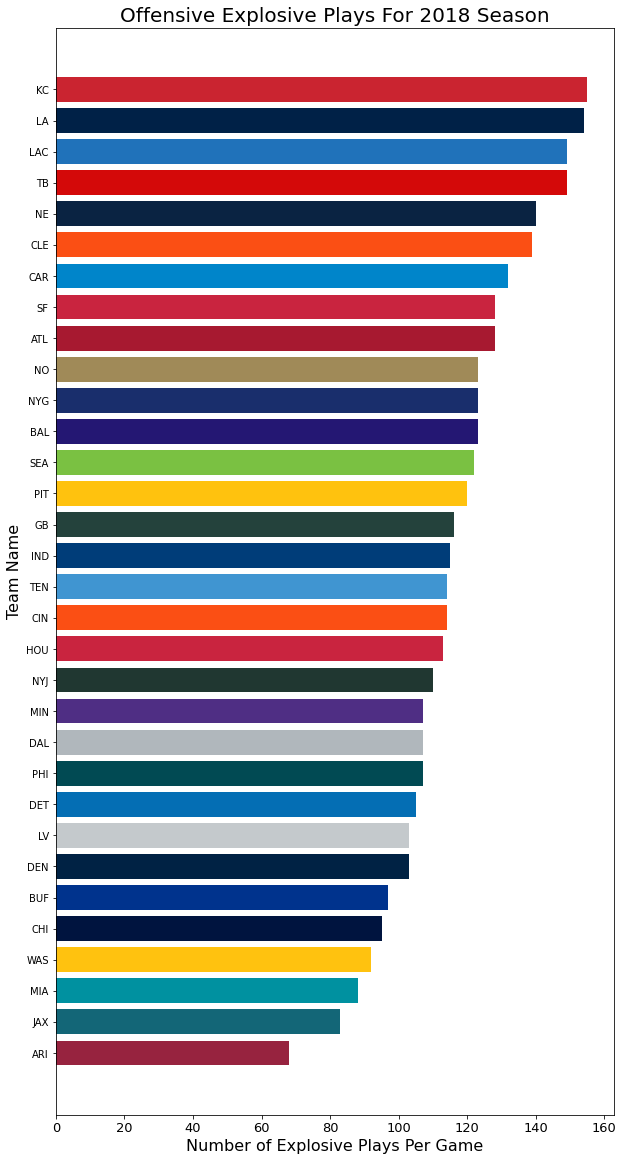

In [90]:
plt.figure(figsize=(10,20))

plt.barh(off_xp_18.Team.sort_index(ascending=False), 
         off_xp_18['Explosive Plays (XP)'].sort_index(ascending=False), 
         color=[COLORS[t] for t in off_xp_18.Team.sort_index(ascending=False)])

plt.title('Offensive Explosive Plays For 2018 Season', fontsize=20)
plt.ylabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.xlabel('Number of Explosive Plays Per Game',fontsize=16)
plt.show()

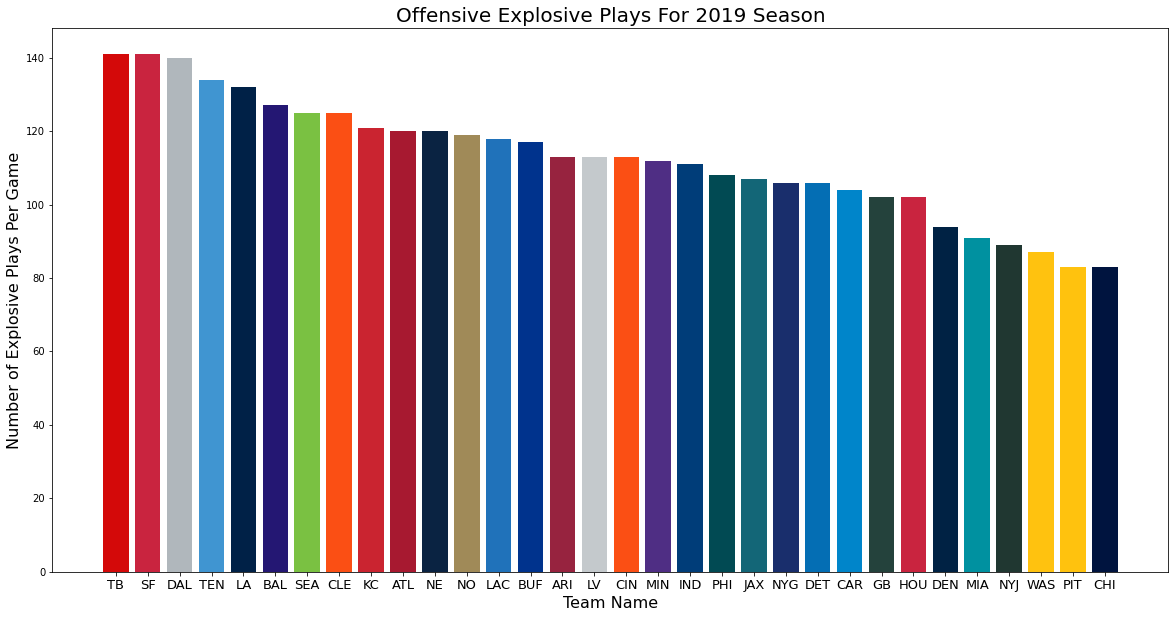

In [91]:
plt.figure(figsize=(20,10))

plt.bar(off_xp_19.Team, 
        off_xp_19['Explosive Plays (XP)'],
        color=[COLORS[t] for t in off_xp_19.Team])

plt.title('Offensive Explosive Plays For 2019 Season', fontsize=20)
plt.xlabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.ylabel('Number of Explosive Plays Per Game',fontsize=16)
plt.show()

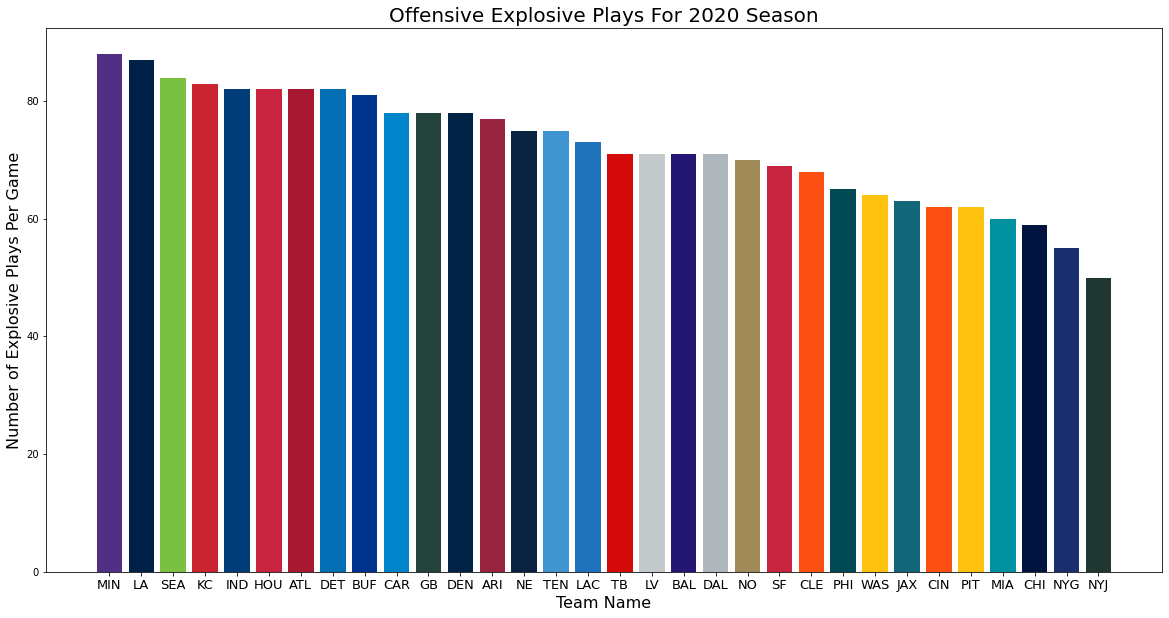

In [92]:
plt.figure(figsize=(20,10))

plt.bar(off_xp_20.Team,
        off_xp_20['Explosive Plays (XP)'],
        color=[COLORS[t] for t in off_xp_20.Team])

plt.title('Offensive Explosive Plays For 2020 Season', fontsize=20)
plt.xlabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.ylabel('Number of Explosive Plays Per Game',fontsize=16)
plt.show()

## NET XP Team Comparison

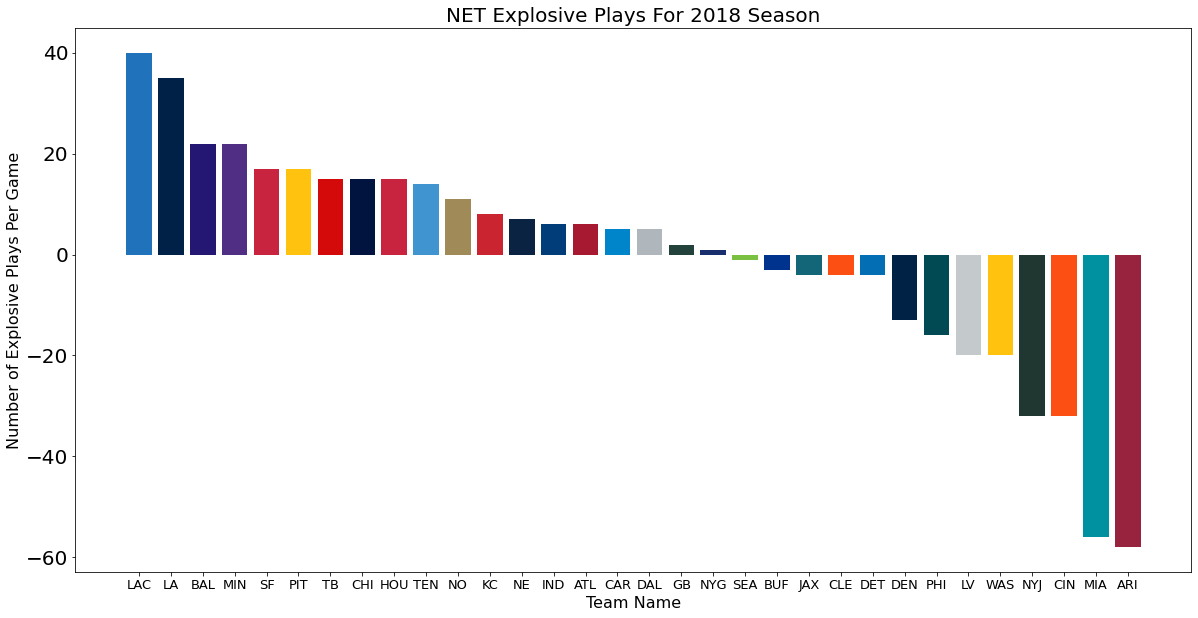

In [233]:
plt.figure(figsize=(20,10))

plt.bar(net_xp_18.Team,
        net_xp_18['NET XP'],
        color=[COLORS[t] for t in net_xp_18.Team])

plt.title('NET Explosive Plays For 2018 Season', fontsize=20)
plt.xlabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.ylabel('Number of Explosive Plays Per Game',fontsize=16)

plt.savefig('net_18.jpg',dpi=400)
plt.show()

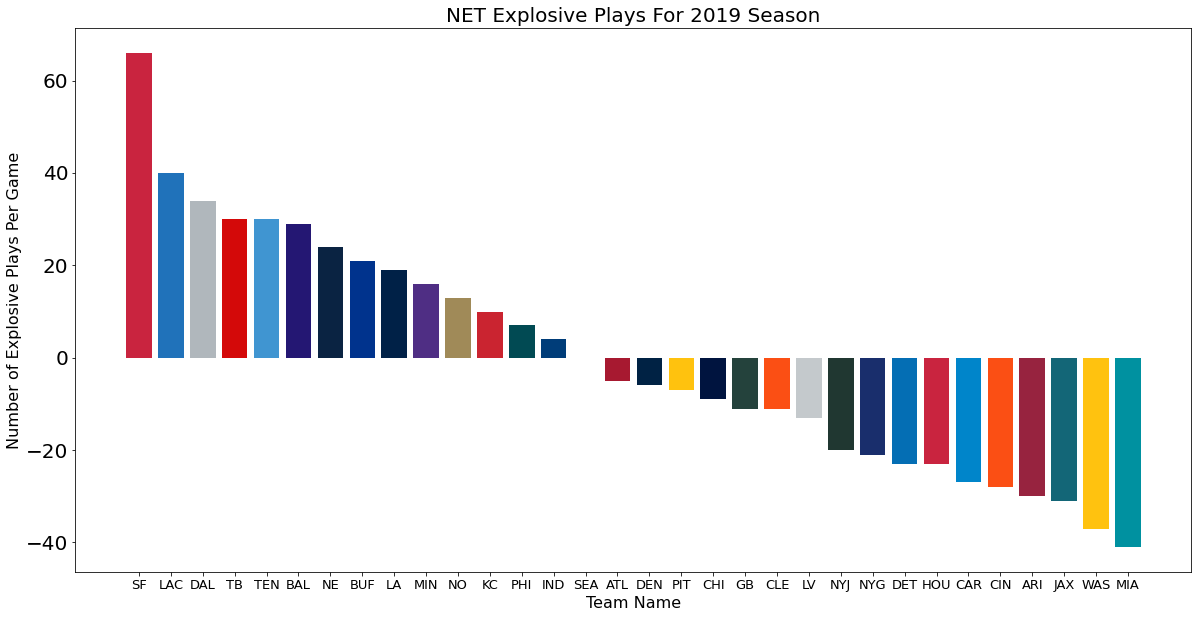

In [234]:
plt.figure(figsize=(20,10))

plt.bar(net_xp_19.Team,
        net_xp_19['NET XP'],
        color=[COLORS[t] for t in net_xp_19.Team])

plt.title('NET Explosive Plays For 2019 Season', fontsize=20)
plt.xlabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.ylabel('Number of Explosive Plays Per Game',fontsize=16)

plt.savefig('net_19.jpg',dpi=400)
plt.show()

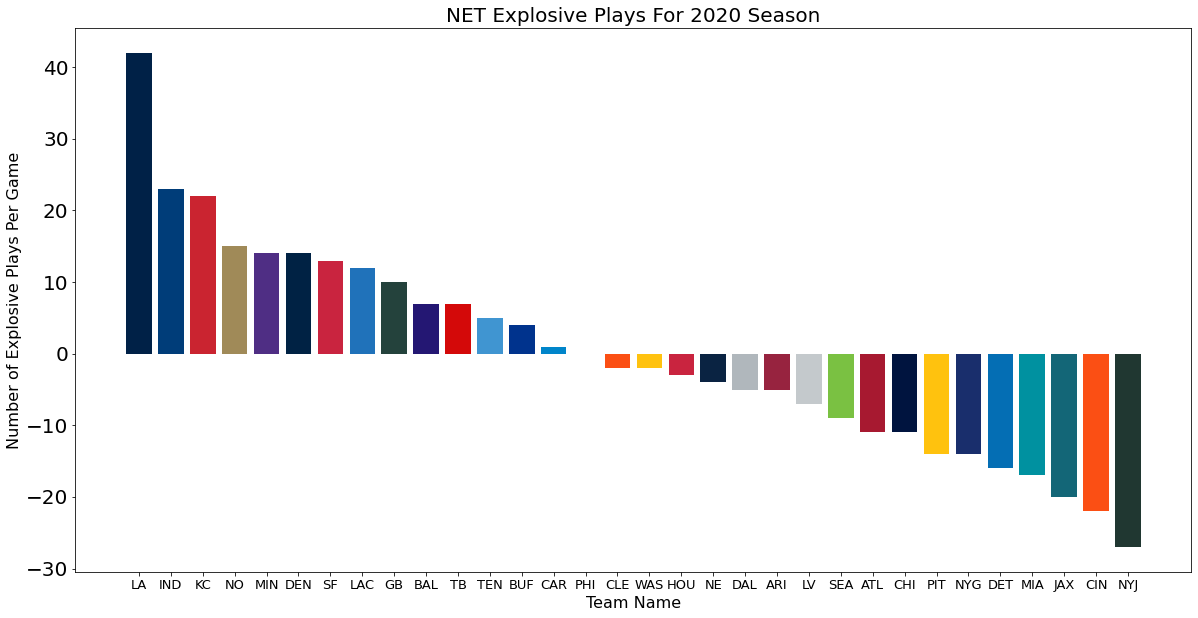

In [235]:
plt.figure(figsize=(20,10))

plt.bar(net_xp_20.Team,
        net_xp_20['NET XP'],
        color=[COLORS[t] for t in net_xp_20.Team])

plt.title('NET Explosive Plays For 2020 Season', fontsize=20)
plt.xlabel('Team Name',fontsize=16)
plt.xticks(fontsize=13)
plt.ylabel('Number of Explosive Plays Per Game',fontsize=16)

plt.savefig('net_20.jpg',dpi=400)
plt.show()

In [106]:
# grab team logos in order to create more eye-catching visualizations

In [113]:
# I will be storing the team logos in a folder named 'logos'
urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')

for i in range(0,len(urls)):
    urllib.request.urlretrieve(urls['url'].iloc[i], os.getcwd() + '/logos/' + urls['team_code'].iloc[i])

In [114]:
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=.5)

In [121]:
# insert folder name where I have logos
logos = os.listdir(os.getcwd() + '/logos')

logos.sort() # sort the list alphabetically

logo_path_dic = {}

logo_paths = []

# insert folder name where I have logos
for i in logos:
    path = os.getcwd() + '/logos/' + str(i)
    logo_paths.append(path)
    logo_path_dic[i[:-4]] = path

In [122]:
# removing teams that moved cities from logos folder
logo_paths.remove('/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/STL.png')
logo_paths.remove('/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/OAK.png')
logo_paths.remove('/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/SD.png')
logo_paths.remove('/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/.DS_Store')


logo_path_dic.pop('STL')
logo_path_dic.pop('OAK')
logo_path_dic.pop('SD')
logo_path_dic.pop('.DS_S')

'/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/.DS_Store'

In [123]:
logo_paths

['/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/ARI.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/ATL.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/BAL.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/BUF.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/CAR.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/CHI.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/CIN.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/CLE.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/DAL.png',
 '/Users/jonhickey/Documents/Flatiron/Phase5/Capstone/NFL-Play-Predictor/reports/logos/DEN.png',
 '/Users/jonhickey/Documents/F

In [ ]:
# if there are any logos not sized correctly, go into the folder where you saved the logos and
# adjust size to preference. I used 1.39

## Team Record DataFrames

In [96]:
# 2018 records for each team
records_18 = pd.DataFrame({
    'Team': ['ARI','ATL','BAL','BUF','CAR','CHI',
          'CIN','CLE','DAL','DEN','DET','GB',
          'HOU','IND','JAX','KC','LA','LAC',
          'LV','MIA','MIN','NE','NO','NYG',
          'NYJ','PHI','PIT','SEA','SF','TB',
          'TEN','WAS'],
    'Wins': [3, 7, 10, 6, 7, 12, 6, 7, 10, 6, 6, 6, 11,
             10, 5, 12, 13, 12, 4, 7, 8, 11, 13, 5, 4,
             9, 9, 10, 4, 5, 9, 7], 
    'Losses': [13, 9, 6, 10, 9, 4, 10, 8, 6, 10, 10, 9, 5,
               6, 11, 4, 3, 4, 12, 9, 7, 5, 3, 11, 12,
               7, 6, 6, 12, 11, 7, 9]})

In [97]:
# merge record data onto net xp data
merged_xp_record_18 = pd.merge(net_xp_18, records_18, on='Team')

In [98]:
# sort our merged data by team name so it matches up with our logos
merged_xp_record_18 = merged_xp_record_18.sort_values('Team')
merged_xp_record_18.head()

,Team,NET XP,NET XP/G,Wins,Losses
31,ARI,-58,-3.63,3,13
14,ATL,6,0.38,7,9
2,BAL,22,1.38,10,6
20,BUF,-3,-0.19,6,10
15,CAR,5,0.31,7,9


In [99]:
# 2019 records for each team
records_19 = pd.DataFrame({
    'Team': ['ARI','ATL','BAL','BUF','CAR','CHI',
          'CIN','CLE','DAL','DEN','DET','GB',
          'HOU','IND','JAX','KC','LA','LAC',
          'LV','MIA','MIN','NE','NO','NYG',
          'NYJ','PHI','PIT','SEA','SF','TB',
          'TEN','WAS'],
    'Wins': [5, 7, 14, 10, 5, 8, 2, 6, 8, 7, 3, 13, 10,
             7, 6, 12, 9, 5, 7, 5, 10, 12, 13, 4, 7, 9,
             8, 11, 13, 7, 9, 3], 
    'Losses': [10, 9, 2, 6, 11, 8, 14, 10, 8, 9, 12, 3, 6,
               9, 10, 4, 7, 11, 9, 11, 6, 4, 3, 12, 9, 7,
               8, 5, 3, 9, 7, 13]})

In [100]:
# merge record data onto net xp data
merged_xp_record_19 = pd.merge(net_xp_19, records_19, on='Team')

In [101]:
# sort our merged data by team name so it matches up with our logos
merged_xp_record_19 = merged_xp_record_19.sort_values('Team')
merged_xp_record_19.head()

,Team,NET XP,NET XP/G,Wins,Losses
28,ARI,-30,-1.88,5,10
15,ATL,-5,-0.31,7,9
5,BAL,29,1.82,14,2
7,BUF,21,1.31,10,6
26,CAR,-27,-1.69,5,11


In [102]:
records_20 = pd.DataFrame({
    'Team': ['ARI','ATL','BAL','BUF','CAR','CHI',
          'CIN','CLE','DAL','DEN','DET','GB',
          'HOU','IND','JAX','KC','LA','LAC',
          'LV','MIA','MIN','NE','NO','NYG',
          'NYJ','PHI','PIT','SEA','SF','TB',
          'TEN','WAS'],
    'Wins': [6, 3, 6, 7, 3, 5, 2, 6, 2, 3, 4, 7, 2, 6,
             1, 8, 6, 2, 6, 6, 4, 4, 7, 3, 0, 3, 9, 7,
             4, 7, 6, 2], 
    'Losses': [4, 6, 3, 3, 7, 5, 6, 3, 7, 6, 5, 2, 7, 3,
               8, 1, 3, 7, 3, 3, 5, 5, 2, 7, 9, 5, 0, 3,
               6, 3, 3, 7]})

In [103]:
# merge record data onto net xp data
merged_xp_record_20 = pd.merge(net_xp_20, records_20, on='Team')

In [104]:
# sort our merged data by team name so it matches up with our logos
merged_xp_record_20 = merged_xp_record_20.sort_values('Team')
merged_xp_record_20.head()

,Team,NET XP,NET XP/G,Wins,Losses
20,ARI,-5,-0.45,6,4
23,ATL,-11,-1.00,3,6
9,BAL,7,0.63,6,3
12,BUF,4,0.36,7,3
13,CAR,1,0.09,3,7


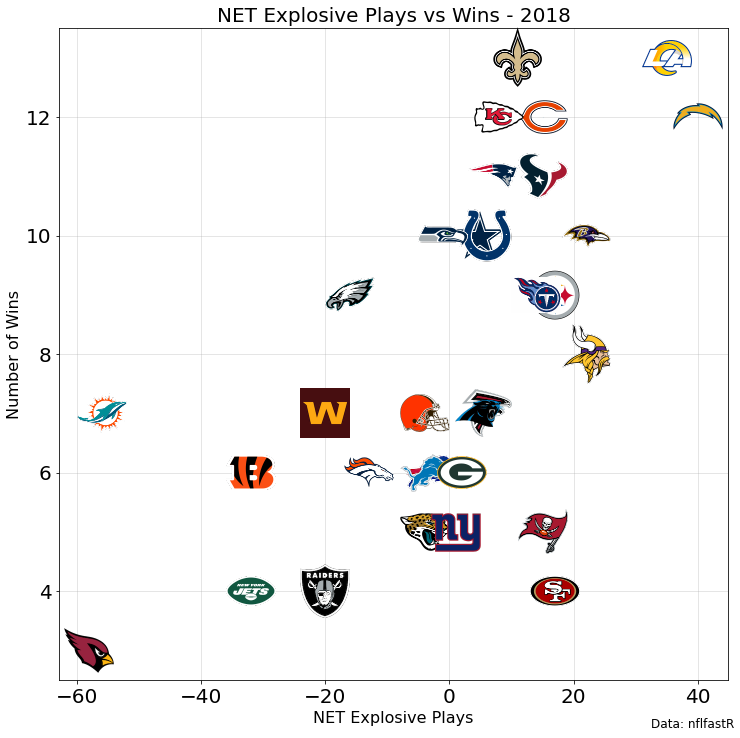

In [236]:
# Define x and y
x = merged_xp_record_18['NET XP']
y = merged_xp_record_18.Wins

# Create a figure with size 12x12
fig, ax = plt.subplots(figsize=(12,12))

# Make a scatter plot first to get the points to place logos
ax.scatter(x, y, s=.001)

# Adding logos to the chart
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
# Add a grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)
    
# Adding labels and text
ax.set_xlabel('NET Explosive Plays', fontsize=16)
ax.set_ylabel('Number of Wins', fontsize=16)
ax.set_title('NET Explosive Plays vs Wins - 2018', fontsize=20)
plt.figtext(.81, .07, 'Data: nflfastR', fontsize=12)

plt.savefig('net_wins_18.jpg',dpi=400)
plt.show()

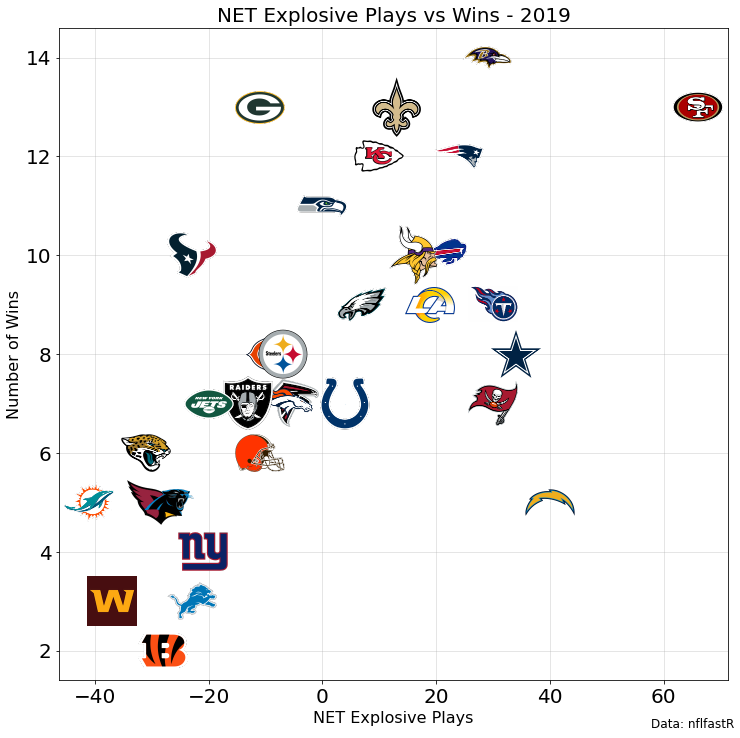

In [237]:
x = merged_xp_record_19['NET XP']
y = merged_xp_record_19.Wins

# Create a figure with size 12x12
fig, ax = plt.subplots(figsize=(12,12))

# Make a scatter plot first to get the points to place logos
ax.scatter(x, y, s=.001)

# Adding logos to the chart
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
# Add a grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)
    
# Adding labels and text
ax.set_xlabel('NET Explosive Plays', fontsize=16)
ax.set_ylabel('Number of Wins', fontsize=16)
ax.set_title('NET Explosive Plays vs Wins - 2019', fontsize=20)
plt.figtext(.81, .07, 'Data: nflfastR', fontsize=12)

plt.savefig('net_wins_19.jpg',dpi=400)
plt.show()

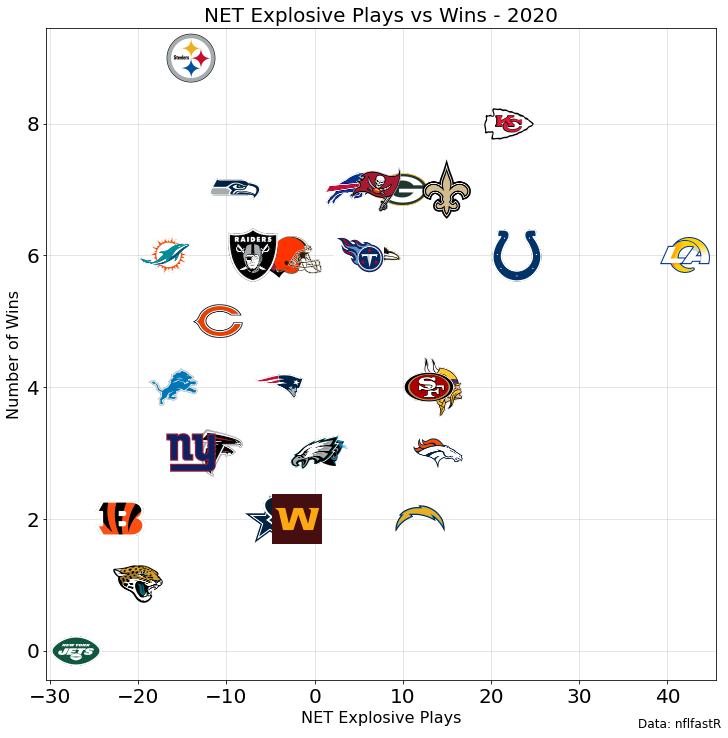

In [238]:
# Define x and y
x = merged_xp_record_20['NET XP']
y = merged_xp_record_20.Wins

# Create a figure with size 12x12
fig, ax = plt.subplots(figsize=(12,12))

# Make a scatter plot first to get the points to place logos
ax.scatter(x, y, s=.001)

# Adding logos to the chart
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)
    
# Add a grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)
    
# Adding labels and text
ax.set_xlabel('NET Explosive Plays', fontsize=16)
ax.set_ylabel('Number of Wins', fontsize=16)
ax.set_title('NET Explosive Plays vs Wins - 2020', fontsize=20)
plt.figtext(.81, .07, 'Data: nflfastR', fontsize=12)

plt.savefig('net_wins_20.jpg',dpi=400)
plt.show()

<ipython-input-252-04c74b05f468>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)


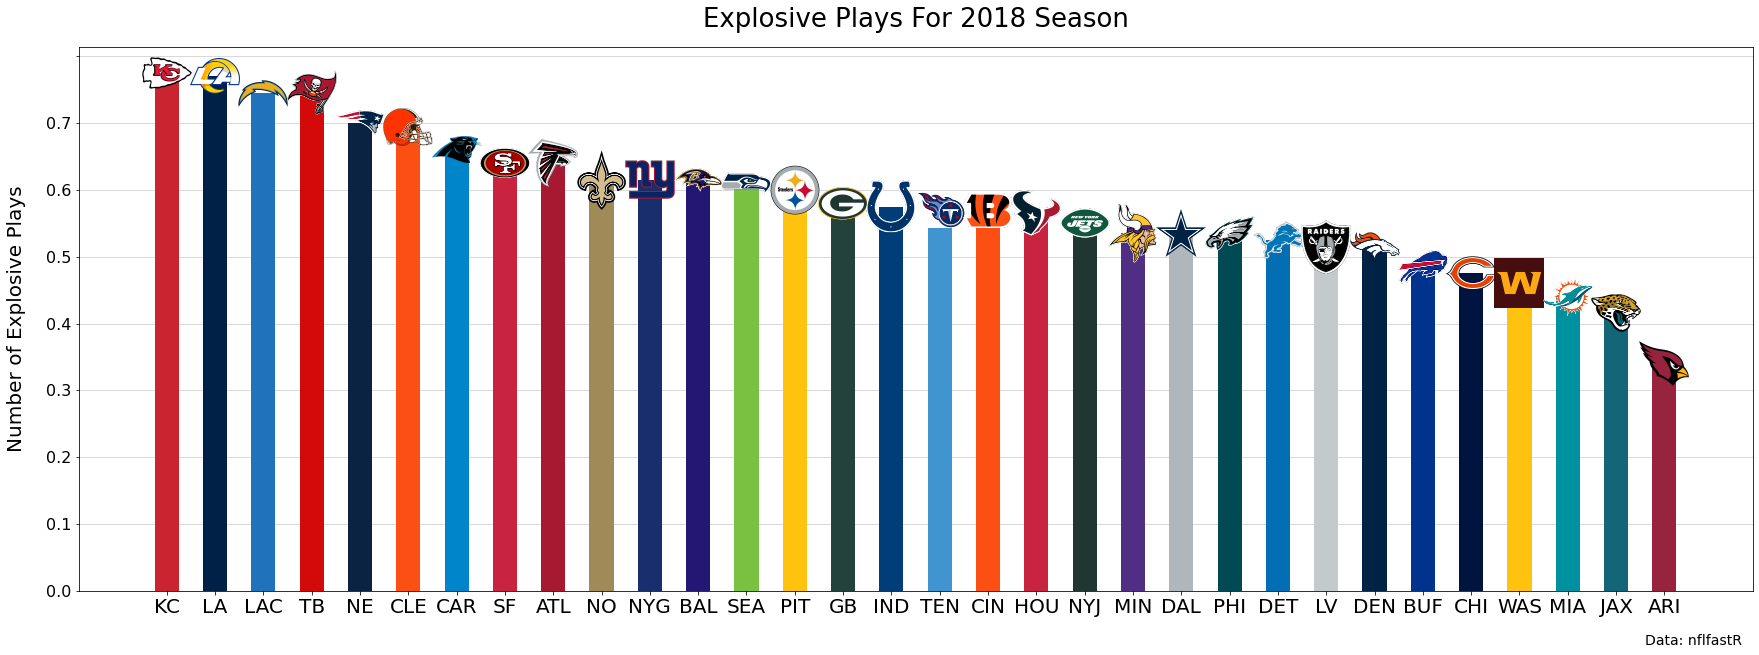

In [252]:
teams = off_xp_18

# Add team colors
teams['color'] = [COLORS[t] for t in off_xp_18.Team]

# Add path column where each row will have the location of the team's logo
teams['path'] = [logo_path_dic[t] for t in off_xp_18.Team]



fig, ax = plt.subplots(figsize=(30,10))

# Add logos
# X data is an array from 0-31 (for 32 teams)
for x0, y0, path in zip(np.arange(0,32),teams['Explosive Plays (XP)']+.005,teams['path']):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

# Create bar chart, setting colors equal to the 32 team color series
ax.bar(np.arange(0,32),teams['Explosive Plays (XP)'], color=teams.color, width=.5)
    
# Add grid
ax.grid(zorder=0,alpha=.6,axis='y')
ax.set_axisbelow(True)

# Set x-ticks labels to be team abbreviations
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(teams.Team,fontsize=20)

# Manually adjust y-axis
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

# Set labels and give source
ax.set_ylabel('Number of Explosive Plays',fontsize=20,labelpad=20)
ax.set_title('Explosive Plays For 2018 Season',
             fontsize=26,pad=20)
plt.figtext(.85,.05,'Data: nflfastR',fontsize=14)

plt.savefig('xp_18.jpg',dpi=5)
plt.show()

<ipython-input-240-772b303ed311>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)


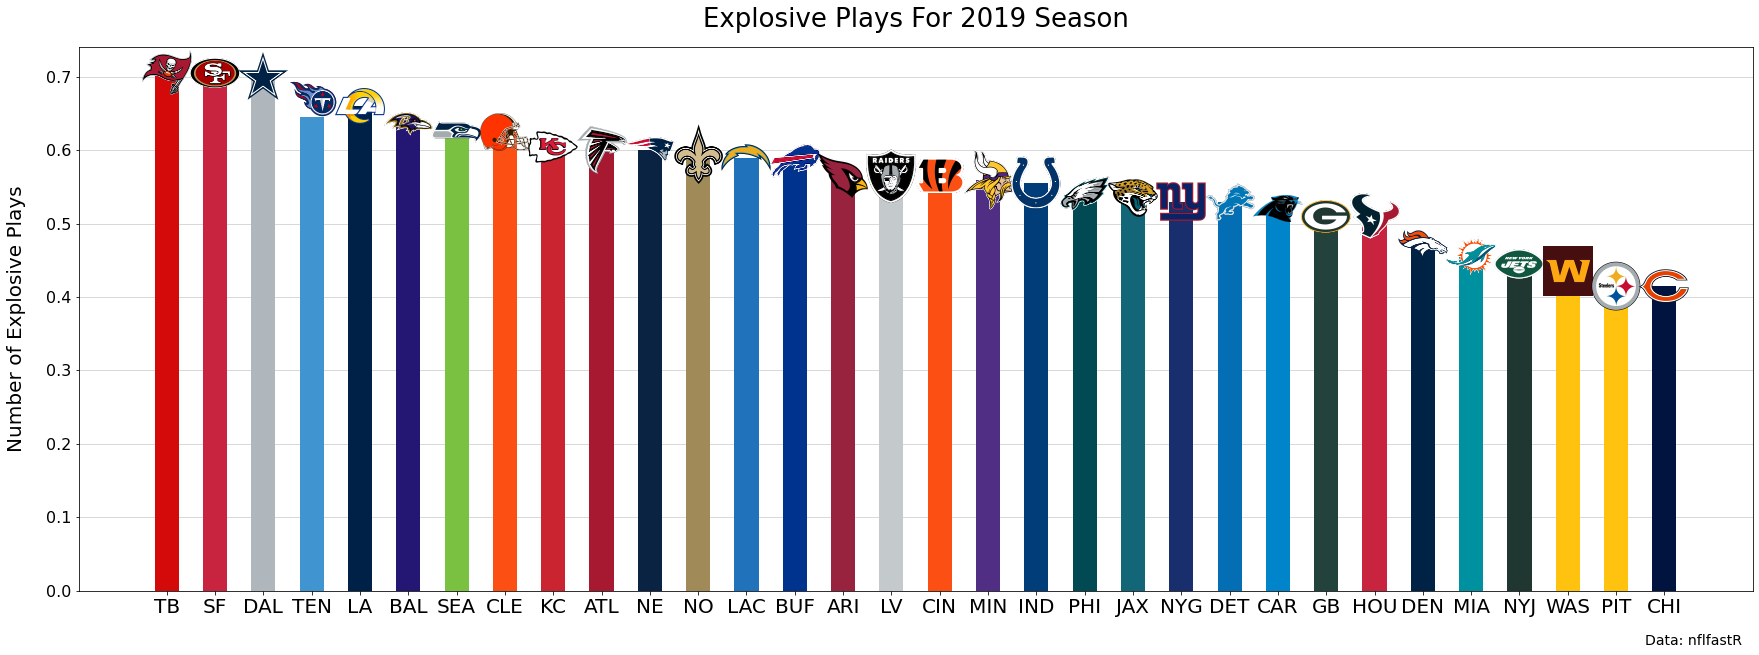

In [240]:
teams = off_xp_19

# Add team colors
teams['color'] = [COLORS[t] for t in off_xp_19.Team]

# Add path column where each row will have the location of the team's logo
teams['path'] = [logo_path_dic[t] for t in off_xp_19.Team]



fig, ax = plt.subplots(figsize=(30,10))

# Add logos
# X data is an array from 0-31 (for 32 teams)
for x0, y0, path in zip(np.arange(0,32),teams['Explosive Plays (XP)']+.005,teams['path']):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

# Create bar chart, setting colors equal to the 32 team color series
ax.bar(np.arange(0,32),teams['Explosive Plays (XP)'], color=teams.color, width=.5)
    
# Add grid
ax.grid(zorder=0,alpha=.6,axis='y')
ax.set_axisbelow(True)

# Set x-ticks labels to be team abbreviations
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(teams.Team,fontsize=20)

# Manually adjust y-axis
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

# Set labels and give source
ax.set_ylabel('Number of Explosive Plays',fontsize=20,labelpad=20)
ax.set_title('Explosive Plays For 2019 Season',
             fontsize=26,pad=20)
plt.figtext(.85,.05,'Data: nflfastR',fontsize=14)

plt.savefig('xp_19.jpg',dpi=400)
plt.show()

<ipython-input-241-858684697489>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)


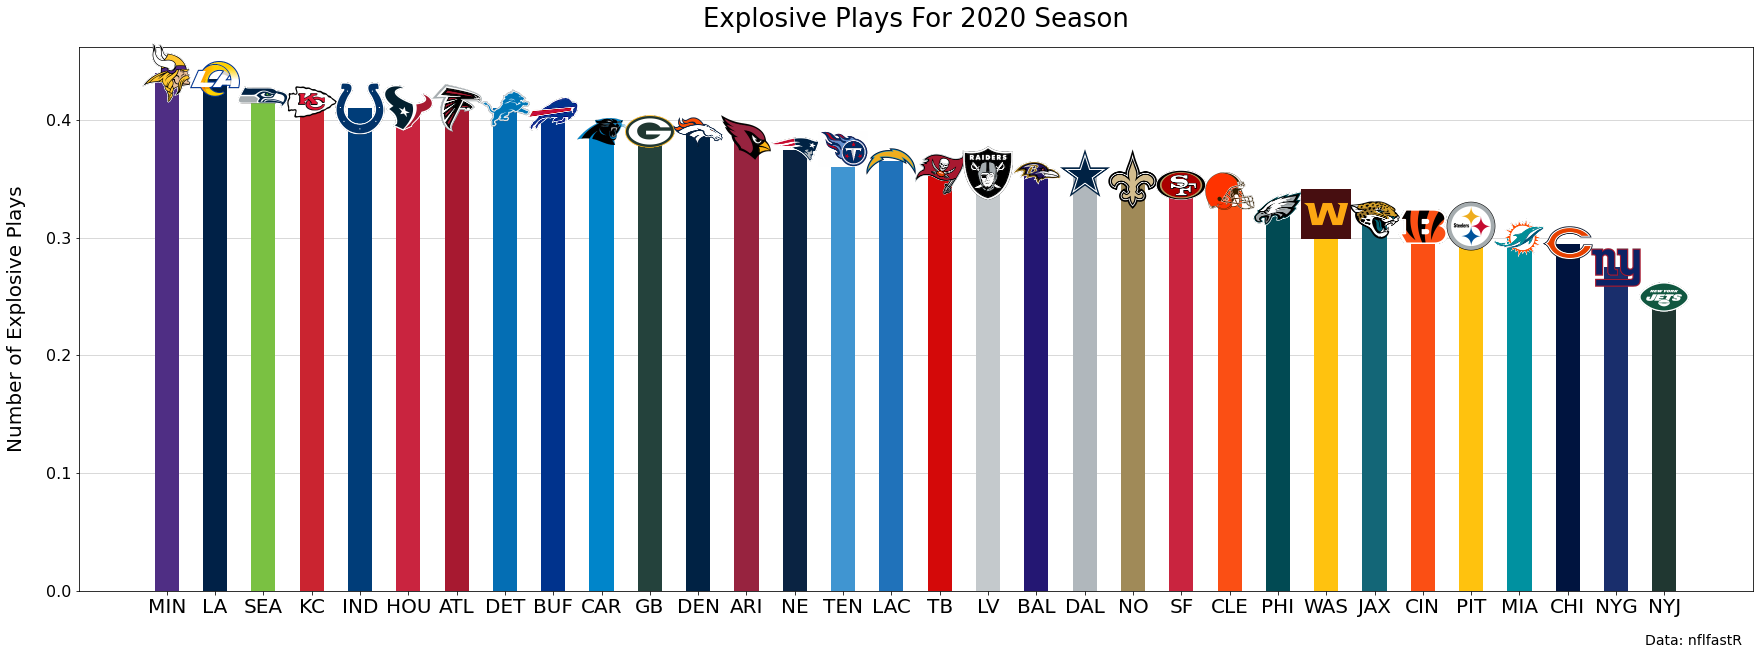

In [241]:
teams = off_xp_20

# Add team colors
teams['color'] = [COLORS[t] for t in off_xp_20.Team]

# Add path column where each row will have the location of the team's logo
teams['path'] = [logo_path_dic[t] for t in off_xp_20.Team]



fig, ax = plt.subplots(figsize=(30,10))

# Add logos
# X data is an array from 0-31 (for 32 teams)
for x0, y0, path in zip(np.arange(0,32),teams['Explosive Plays (XP)']+.005,teams['path']):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

# Create bar chart, setting colors equal to the 32 team color series
ax.bar(np.arange(0,32),teams['Explosive Plays (XP)'], color=teams.color, width=.5)
    
# Add grid
ax.grid(zorder=0,alpha=.6,axis='y')
ax.set_axisbelow(True)

# Set x-ticks labels to be team abbreviations
ax.set_xticks(np.arange(0,32))
ax.set_xticklabels(teams.Team,fontsize=20)

# Manually adjust y-axis
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

# Set labels and give source
ax.set_ylabel('Number of Explosive Plays',fontsize=20,labelpad=20)
ax.set_title('Explosive Plays For 2020 Season',
             fontsize=26,pad=20)
plt.figtext(.85,.05,'Data: nflfastR',fontsize=14)

plt.savefig('xp_20.jpg',dpi=400)
plt.show()

## Modeling

In [40]:
run_pass_df.head()

,yardline_100,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,quarter_minutes_remaining,half_minutes_remaining,game_minutes_remaining,Target
3,80.0,1.0,1,1.0,0,15,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,15.00,30.00,60.00,1
4,70.0,1.0,1,2.0,0,5,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,14.37,29.37,59.37,0
5,59.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,13.77,28.77,58.77,0
6,39.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,13.17,28.17,58.17,1
7,39.0,1.0,1,2.0,0,10,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,13.08,28.08,58.08,1


In [41]:
# prepare for the train_test_split
X = run_pass_df.drop('Target', axis=1)
y = run_pass_df.Target

In [42]:
# perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.20)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70683, 17), (17671, 17), (70683,), (17671,))

In [44]:
# creating pipeline to do preprocessing for us
preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
                                       (StandardScaler(), make_column_selector(dtype_include=np.number)))

preprocessing

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])

In [131]:
# the next thing we'll do is make separate pipelines for each model we want to test
# each of these pipelines will contain our preprocessing pipeline

dt_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("dt", DecisionTreeClassifier(random_state=2020))])
rf_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("rf", RandomForestClassifier(random_state=2020))])
lr_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("lr", LogisticRegression(random_state=2020))])
et_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("et", ExtraTreesClassifier(random_state=2020))])
kn_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("kn", KNeighborsClassifier())])

In [132]:
# different param_grids for each pipeline

dt_param_grid = {
    'dt__criterion': ['entropy', 'gini'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': [2, 5, 10],
    'dt__max_features': ['auto', 'sqrt', 'log2'],
    'dt__class_weight': ['none', 'balanced']
    
}

rf_param_grid = {
    'rf__n_estimators': [10, 100],
    'rf__max_depth': [2, 5, 10]
    
}

lr_param_grid = {
    'lr__penalty': ['l2'],
    'lr__dual': [False],
    'lr__solver': ['lbfgs'],
    'lr__multi_class': ['multinomial'],
    'lr__n_jobs': [10],
    'lr__C': [0.1]
    
}

et_param_grid = {
    'et__criterion': ['entropy', 'gini'],
    'et__max_depth': [2, 5, 10],
    'et__n_estimators': [10, 100],
    'et__max_features': ['auto', 'sqrt', 'log2'],
    'et__class_weight': ['none', 'balanced']
    
}

kn_param_grid = {
    'kn__n_neighbors': [2, 3],
    'kn__weights': ['uniform', 'distance'],
    'kn__p': [1, 2]
    
}

## LogisticRegression

In [133]:
search_lr = GridSearchCV(lr_pipeline, lr_param_grid, n_jobs=-1)

search_lr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])),
                                       ('smote', SMOTE()),
                                       ('lr',
                                        LogisticRegression(random_state=2020))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1], 'lr__dual': [False]

In [134]:
# we can check its best parameters
search_lr.best_params_

{'lr__C': 0.1,
 'lr__dual': False,
 'lr__multi_class': 'multinomial',
 'lr__n_jobs': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs'}

In [135]:
# assign best model to a variable using best_estimator_
best_lr_pipeline = search_lr.best_estimator_

In [136]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_lr_cross_val_acc = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='accuracy')
best_lr_cross_val_prec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='precision')
best_lr_cross_val_rec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='recall')
best_lr_cross_val_f1 = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='f1')

## DecisionTree

In [137]:
search_dt = GridSearchCV(dt_pipeline, dt_param_grid, n_jobs=-1)

search_dt.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])),
                                       ('smote', SMOTE()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'dt__class_weight': ['none', 'b

In [138]:
# we can check its best parameters
search_dt.best_params_

{'dt__class_weight': 'balanced',
 'dt__criterion': 'gini',
 'dt__max_depth': 5,
 'dt__max_features': 'sqrt',
 'dt__splitter': 'best'}

In [139]:
# assign best model to a variable using best_estimator_
best_dt_pipeline = search_dt.best_estimator_

In [140]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_dt_cross_val_acc = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='accuracy')
best_dt_cross_val_prec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='precision')
best_dt_cross_val_rec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='recall')
best_dt_cross_val_f1 = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='f1')

## RandomForest

In [141]:
search_rf = GridSearchCV(rf_pipeline, rf_param_grid, n_jobs=-1)

search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])),
                                       ('smote', SMOTE()),
                                       ('rf',
                                        RandomForestClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 5, 10],
  

In [142]:
# we can check its best parameters
search_rf.best_params_

{'rf__max_depth': 5, 'rf__n_estimators': 100}

In [143]:
# assign best model to a variable using best_estimator_
best_rf_pipeline = search_rf.best_estimator_

In [144]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_rf_cross_val_acc = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='accuracy')
best_rf_cross_val_prec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='precision')
best_rf_cross_val_rec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='recall')
best_rf_cross_val_f1 = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='f1')

## ExtraTrees

In [145]:
search_et = GridSearchCV(et_pipeline, et_param_grid, n_jobs=-1)

search_et.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])),
                                       ('smote', SMOTE()),
                                       ('et',
                                        ExtraTreesClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'et__class_weight': ['none', 'bal

In [146]:
# we can check its best parameters
search_et.best_params_

{'et__class_weight': 'balanced',
 'et__criterion': 'gini',
 'et__max_depth': 5,
 'et__max_features': 'sqrt',
 'et__n_estimators': 100}

In [147]:
# assign best model to a variable using best_estimator_
best_et_pipeline = search_et.best_estimator_

In [148]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_et_cross_val_acc = cross_val_score(best_et_pipeline, X_train, y_train, scoring='accuracy')
best_et_cross_val_prec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='precision')
best_et_cross_val_rec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='recall')
best_et_cross_val_f1 = cross_val_score(best_et_pipeline, X_train, y_train, scoring='f1')

## KNeighbors

In [149]:
search_kn = GridSearchCV(kn_pipeline, kn_param_grid, n_jobs=-1)

search_kn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5efa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe0fa5e2e0>)])),
                                       ('smote', SMOTE()),
                                       ('kn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kn__n_neighbors': [2, 3], 'kn__p': [1, 2],
                         'kn__weights': ['unif

In [150]:
# we can check its best parameters
search_kn.best_params_

{'kn__n_neighbors': 3, 'kn__p': 1, 'kn__weights': 'uniform'}

In [151]:
# assign best model to a variable using best_estimator_
best_kn_pipeline = search_kn.best_estimator_

In [152]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_kn_cross_val_acc = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='accuracy')
best_kn_cross_val_prec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='precision')
best_kn_cross_val_rec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='recall')
best_kn_cross_val_f1 = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='f1')

## Comparison of Models Using Cross-Validation Metrics

In [153]:
models = pd.DataFrame({
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 
              'ExtraTrees', 'KNeighbors'], 
    'Accuracy': [best_lr_cross_val_acc.mean(), best_dt_cross_val_acc.mean(), best_rf_cross_val_acc.mean(), 
               best_et_cross_val_acc.mean(), best_kn_cross_val_acc.mean()], 
    'Precision': [best_lr_cross_val_prec.mean(), best_dt_cross_val_prec.mean(), best_rf_cross_val_prec.mean(), 
               best_et_cross_val_prec.mean(), best_kn_cross_val_prec.mean()], 
    'Recall': [best_lr_cross_val_rec.mean(), best_dt_cross_val_rec.mean(), best_rf_cross_val_rec.mean(), 
               best_et_cross_val_rec.mean(), best_kn_cross_val_rec.mean()],
    'F1 Score': [best_lr_cross_val_f1.mean(), best_dt_cross_val_f1.mean(), best_rf_cross_val_f1.mean(), 
               best_et_cross_val_f1.mean(), best_kn_cross_val_f1.mean()]}) 

In [154]:
models.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,ExtraTrees,0.735226,0.790082,0.786192,0.787200
0,LogisticRegression,0.730855,0.806103,0.749457,0.776844
2,RandomForest,0.729652,0.818686,0.732186,0.770825
1,DecisionTree,0.696631,0.812081,0.737475,0.788772
4,KNeighbors,0.677390,0.765241,0.702460,0.733396


In [155]:
models.sort_values('Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
2,RandomForest,0.729652,0.818686,0.732186,0.770825
1,DecisionTree,0.696631,0.812081,0.737475,0.788772
0,LogisticRegression,0.730855,0.806103,0.749457,0.776844
3,ExtraTrees,0.735226,0.790082,0.786192,0.787200
4,KNeighbors,0.677390,0.765241,0.702460,0.733396


In [156]:
models.sort_values('F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
1,DecisionTree,0.696631,0.812081,0.737475,0.788772
3,ExtraTrees,0.735226,0.790082,0.786192,0.787200
0,LogisticRegression,0.730855,0.806103,0.749457,0.776844
2,RandomForest,0.729652,0.818686,0.732186,0.770825
4,KNeighbors,0.677390,0.765241,0.702460,0.733396


In [157]:
models.sort_values('Recall', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,ExtraTrees,0.735226,0.790082,0.786192,0.787200
0,LogisticRegression,0.730855,0.806103,0.749457,0.776844
1,DecisionTree,0.696631,0.812081,0.737475,0.788772
2,RandomForest,0.729652,0.818686,0.732186,0.770825
4,KNeighbors,0.677390,0.765241,0.702460,0.733396


Based on these cross-validation metrics, I chose to proceed with ExtraTrees as my final model due to its high performance in recall score.

I chose recall score as my metric because I believe its more detrimental to falsely predict a run play than a pass play, as more explosive plays occured in the air vs on the ground. We should want to minimize these false negative predictions so our defense isn't caught with run play personnel on the field when it needs pass play personnel, or they've decided to call a blitz when they actually need to be in prevent defense.

## Final Model

In [159]:
# refit training data onto best model
best_et_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe2ac5b700>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbdf99053a0>)])),
                ('smote', SMOTE()),
                ('et',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                      max_features='sqrt',
                                      random_state=2020))])

In [160]:
et_cross_val_acc_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='accuracy').mean()
et_cross_val_prec_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='precision').mean()
et_cross_val_rec_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='recall').mean()
et_cross_val_f1_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='f1').mean()

In [161]:
final_model_comp = pd.DataFrame({
    'Model': ['ExtraTrees Train', 'ExtraTrees Test'], 
    'Accuracy': [best_et_cross_val_acc.mean(), et_cross_val_acc_test], 
    'Precision': [best_et_cross_val_prec.mean(), et_cross_val_prec_test], 
    'Recall': [best_et_cross_val_rec.mean(), et_cross_val_rec_test],
    'F1 Score': [best_et_cross_val_f1.mean(), et_cross_val_f1_test]}) 

In [162]:
final_model_comp

,Model,Accuracy,Precision,Recall,F1 Score
0,ExtraTrees Train,0.735226,0.790082,0.786192,0.78720
1,ExtraTrees Test,0.734084,0.779788,0.799671,0.78897


## ExtraTrees Feature Importance

In [163]:
best_et_pipeline.steps[2][1].feature_importances_

array([0.00268792, 0.00954548, 0.01087105, 0.14860633, 0.00298052,
       0.03193502, 0.57779676, 0.01228969, 0.0266982 , 0.00266611,
       0.00519082, 0.01480134, 0.01512278, 0.08760009, 0.01521621,
       0.02411544, 0.01187624])

In [164]:
feat_imp_df = pd.DataFrame(best_et_pipeline.steps[2][1].feature_importances_.round(decimals=3), index=X_train.columns)

In [165]:
feat_imp_df.rename({0: 'Importance'}, axis=1, inplace=True)

In [166]:
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

In [232]:
feat_imp_df

,Importance
yardline_100,0.003
goal_to_go,0.003
defteam_timeouts_remaining,0.003
posteam_score,0.005
drive,0.010
qtr,0.011
no_huddle,0.012
game_minutes_remaining,0.012
defteam_score,0.015
score_differential,0.015


<ipython-input-243-6f5533b34de8>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feat_imp_df.index, fontsize=22)
<ipython-input-243-6f5533b34de8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feat_imp_df.Importance, fontsize=22)


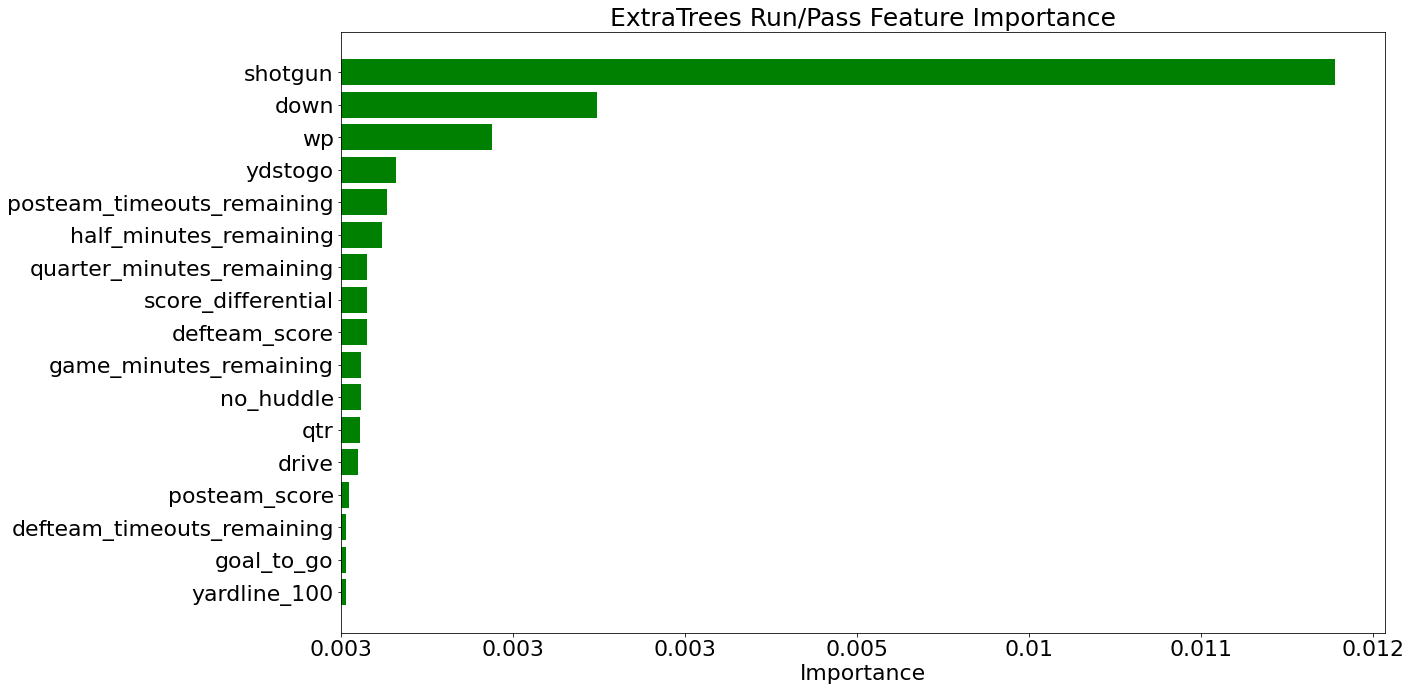

In [243]:
# the features that were most important to the model

fig,ax = plt.subplots(figsize=(20,10))
plt.barh(feat_imp_df.index, feat_imp_df.Importance, color='g')
plt.title('ExtraTrees Run/Pass Feature Importance', fontsize=25)
plt.xlabel('Importance', fontsize=22)
ax.set_yticklabels(feat_imp_df.index, fontsize=22)
ax.set_xticklabels(feat_imp_df.Importance, fontsize=22)
plt.tight_layout()

plt.savefig('feat_imp.jpg',dpi=400)
plt.show()

## Confusion Matrix

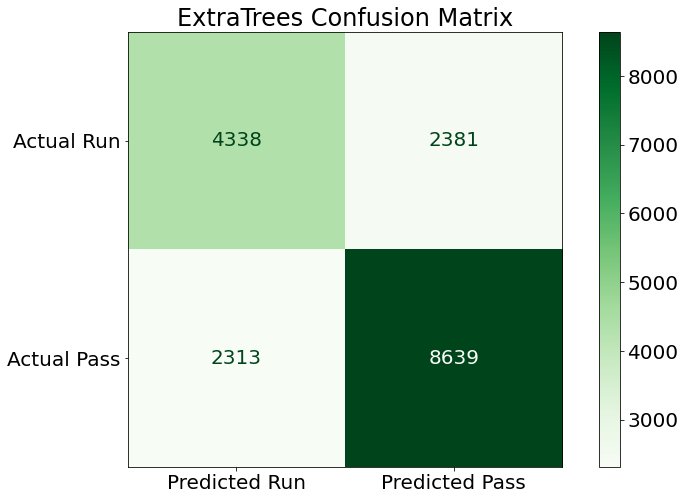

In [244]:
fig, axes = plt.subplots(figsize=(13,8))

plot_confusion_matrix(best_et_pipeline, X_test, y_test, ax=axes, cmap='Greens')

axes.set_title('ExtraTrees Confusion Matrix')
axes.xaxis.set_ticklabels(['Predicted Run', 'Predicted Pass']);
axes.yaxis.set_ticklabels(['Actual Run', 'Actual Pass']);
axes.set_xlabel('')
axes.set_ylabel('')

plt.rc('font', size=20)

plt.savefig('cm.jpg',dpi=400)
plt.show()

From the confusion matrix, you can see that the model correctly predicted 4,338 run plays and 8,639 pass plays. Alternatively, the model incorrectly predicted 2,313 run plays and 2,381 pass plays.

In my project context, I believe its more detrimental to falsely predict a run that turns out to be a pass, therefore I want to keep the false negative value (lower left hand corner) as minimal as possible.

## Save Final Model as Pickle

In [208]:
# the purpose of pickling my final model is to be able to deploy it for the use of inputing 
# real-time play information

import pickle as pkl

# saved it as .p because I wanted to push model to github repo without pushin my other larger
# .pkl files
file = open('final_pipeline.p', 'wb')
pkl.dump(best_et_pipeline, file)
file.close()